In [4]:
import pandas as pd
import numpy as np
import re
import yfinance as yf
import datetime
# Import the plotting library
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
%matplotlib inline

In [5]:
# #data = yf.download('BHARATRAS.NS','2016-01-01','2021-08-01')
# data = yf.download('^NSEI','2016-01-01','2021-08-01')
# # Plot the close price of the AAPL
# data['Adj Close'].plot()
# #data['Close'].plot()
# plt.show()

In [6]:
# import pandas as pd
# tickers_list = ['AAPL', 'WMT', 'IBM', 'MU', 'BA', 'AXP']

# # Fetch the data
# data = yf.download(tickers_list,'2015-1-1')['Adj Close']
# #data = yf.download("SPY AAPL MSFT",'2015-1-1',group_by = 'ticker',threads = True)#['Close']
# #data = yf.download(tickers_list,'2015-1-1',group_by = 'ticker',threads = True)#['Close']

# # Print first 5 rows of the data
# print(data.shape)
# print(data.head())

In [7]:
df_analysis = pd.read_csv('df_validations_2021.csv').set_index('Unnamed: 0')
df_analysis.head(4)

,Tikr_x,Sales_yr_1,Sales_yr_2,Sales_yr_3,Sales_yr_4,Sales_yr_5,Sales_yr_2_YoY,Sales_yr_3_YoY,Sales_yr_4_YoY,Sales_yr_5_YoY,...,lgb_label,xgb_label,rf_label,RandomForest_Bucket,XgBoost_Bucket,LGBM_Bucket,rf_decile,lgb_decile,xgb_decile,Return_AD
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,20MICRONS,333.00,357.00,385.00,436.00,490.00,7.207207,7.843137,13.246753,12.385321,...,0,0,0,Bin 11-20,Bin 11-20,Bin 1-10,Decile_02,Decile_07,Decile_08,9.902882
1,21STCENMGM,2.88,1.92,10.51,8.58,-9.71,-33.333333,447.395833,-18.363463,-213.170163,...,0,0,0,Bin 21-30,Bin 1-10,Bin 1-10,Decile_06,Decile_06,Decile_05,-21.452053
2,3IINFOTECH,1431.00,1521.00,1833.00,2076.00,1870.00,6.289308,20.512821,13.256956,-9.922929,...,0,0,0,Bin 1-10,Bin 1-10,Bin 1-10,Decile_01,Decile_05,Decile_05,55.028298
3,3MINDIA,2140.00,2363.00,2556.00,2809.00,2765.00,10.420561,8.167584,9.898279,-1.566394,...,0,0,0,Bin 41-50,Bin 11-20,Bin 11-20,Decile_10,Decile_09,Decile_07,16.497658


In [8]:
df_analysis['Avg_Score'] = df_analysis[['lgb_score','xgb_score','rf_score']].mean(axis=1)
df_analysis[['lgb_score','xgb_score','rf_score','Avg_Score']].head()

,lgb_score,xgb_score,rf_score,Avg_Score
Unnamed: 0,,,,
0,0.056438,0.160940,0.1300,0.115793
1,0.036056,0.075842,0.2475,0.119799
2,0.027975,0.082192,0.0900,0.066722
3,0.137286,0.133918,0.4300,0.233735
4,0.086801,0.126149,0.2750,0.162650


In [9]:
bins = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
labels = ["Bin 1-10","Bin 11-20","Bin 21-30","Bin 31-40","Bin 41-50","Bin 51-60","Bin 61-70","Bin 71-80","Bin 81-90","Bin 91-100"]
df_analysis['Main_decile'] = pd.qcut(df_analysis['Avg_Score'], 10, labels=False)+1
df_analysis['Main_decile'] = 'Decile_' + df_analysis['Main_decile'].astype(str).str.pad(2,fillchar='0')
df_analysis['Main_Bucket'] = pd.cut(df_analysis['Avg_Score'], bins, labels = labels,include_lowest = True)

# Performance Based Decile
df_analysis['Return_Norm'] = (df_analysis['Return'] - df_analysis['Return'].min()) / (df_analysis['Return'].max() - df_analysis['Return'].min())
df_analysis['Performance_decile'] = pd.qcut(df_analysis['Return_Norm'], 10, labels=False)+1
df_analysis['Performance_decile'] = 'Decile_' + df_analysis['Performance_decile'].astype(str).str.pad(2,fillchar='0')
df_analysis['Performance_Bucket'] = pd.cut(df_analysis['Return_Norm'], bins, labels = labels,include_lowest = True)


In [10]:
#df_analysis['Main_Bucket'].value_counts()
df_analysis['Performance_decile'].value_counts()
# There are approx 100 shares in top 3 buckets

Decile_05    137
Decile_09    137
Decile_04    137
Decile_01    137
Decile_02    137
Decile_08    137
Decile_03    137
Decile_10    137
Decile_07    137
Decile_06    136
Name: Performance_decile, dtype: int64

In [11]:
df_analysis['Main_decile'].value_counts()
# 137 shares in the top decile 

Decile_05    137
Decile_04    137
Decile_09    137
Decile_01    137
Decile_02    137
Decile_08    137
Decile_03    137
Decile_10    137
Decile_07    137
Decile_06    136
Name: Main_decile, dtype: int64

<AxesSubplot:xlabel='None-Performance_decile', ylabel='Main_decile'>

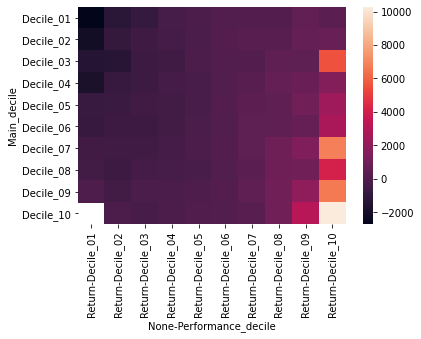

In [12]:
# What is the distribution of Performance decile in Main Decile, 
# How many top performing stocks were part of 

df_heatmap_count = pd.pivot_table(df_analysis, index=['Main_decile'], columns=['Performance_decile'], values=['Return'], aggfunc='count')
df_heatmap_avg = pd.pivot_table(df_analysis, index=['Main_decile'], columns=['Performance_decile'], values=['Return'], aggfunc='mean')
df_heatmap_sum = pd.pivot_table(df_analysis, index=['Main_decile'], columns=['Performance_decile'], values=['Return'], aggfunc='sum')
sns.heatmap(df_heatmap_sum, annot=False)

In [13]:
df_heatmap_sum

Return                                       \
Performance_decile    Decile_01    Decile_02   Decile_03   Decile_04   
Main_decile                                                            
Decile_01          -2723.933902 -1268.031816 -849.826755 -303.331328   
Decile_02          -2113.468169  -924.104574 -575.125190 -379.867384   
Decile_03          -1419.409880 -1308.198845 -636.891692 -495.059247   
Decile_04          -1806.791585  -823.372288 -612.509971 -345.230278   
Decile_05           -790.614787  -741.459214 -478.130013 -389.592831   
Decile_06           -792.863063  -639.496689 -636.472672 -415.607887   
Decile_07           -438.109060  -501.204850 -495.518055 -343.435539   
Decile_08           -403.586252  -661.339905 -379.777052 -294.696679   
Decile_09            -66.113172  -418.164539 -181.166429 -154.220885   
Decile_10                   NaN  -112.740388 -241.297609 -125.537814   

                                                                     \
Performance_decile   Decile_05   Decile_06   Decile_07    Decile_08   
Main_decile                                                           
Decile_01          -124.939470   44.230999  120.477854    92.994491   
Decile_02          -172.172722   90.285818  233.313255   251.902977   
Decile_03          -109.841438   64.897385  120.890636   488.301355   
Decile_04          -187.386066   60.566470  240.302018   660.194917   
Decile_05          -224.347710   72.637016  379.450098   520.859231   
Decile_06          -152.662517   49.083185  477.308318   521.149990   
Decile_07          -130.178757   72.715946  430.043812   894.832934   
Decile_08          -185.077256   65.881939  365.959917   910.962988   
Decile_09           -58.305013  111.388253  516.994739  1025.143870   
Decile_10           -22.233516   66.999220  296.103697  1048.420262   

                                               
Performance_decile    Decile_09     Decile_10  
Main_decile                                    
Decile_01            577.064117    340.178580  
Decile_02            677.172487    754.043151  
Decile_03            452.547379   5589.540656  
Decile_04            791.985317   1631.259198  
Decile_05           1055.247034   2391.297064  
Decile_06            709.274203   2737.535419  
Decile_07           1455.694751   6788.413742  
Decile_08           1013.764987   4112.899143  
Decile_09           1993.781908   6629.309203  
Decile_10           3143.341591  10288.610901

In [25]:
# Lets pick up top 3 buckets and crete portfolio out of it
#selected_tikrs = df_analysis['Tikr_x'][df_analysis['Main_Bucket'].isin(['Bin 91-100','Bin 81-90','Bin 71-80'])].to_list()
# # Bins based filtering
# selected_tikrs = df_analysis['Tikr_x'][df_analysis['Main_Bucket'].isin(['Bin 91-100','Bin 81-90'])].to_list()
# DEcile based filtering
#selected_tikrs = df_analysis['Tikr_x'][df_analysis['Main_decile'].isin(['Decile_10'])].to_list()
selected_tikrs = df_analysis['Tikr_x'][df_analysis['Main_decile'].isin(['Decile_10','Decile_09'])].to_list()
selected_tikrs = [s + '.NS' for s in selected_tikrs]
selected_tikrs.append('^NSEI')
selected_tikrs

['3MINDIA.NS',
 'AARTIDRUGS.NS',
 'AARTIIND.NS',
 'AAVAS.NS',
 'ABBOTINDIA.NS',
 'ACC.NS',
 'ADANIENT.NS',
 'ADANIGAS.NS',
 'AIAENG.NS',
 'AJANTPHARM.NS',
 'AKZOINDIA.NS',
 'ALKEM.NS',
 'ALKYLAMINE.NS',
 'AMARAJABAT.NS',
 'AMBER.NS',
 'AMBUJACEM.NS',
 'ANDHRSUGAR.NS',
 'APLLTD.NS',
 'APOLLOHOSP.NS',
 'ARMANFIN.NS',
 'ASHOKA.NS',
 'ASIANPAINT.NS',
 'ASTERDM.NS',
 'ASTRAL.NS',
 'ASTRAZEN.NS',
 'ATUL.NS',
 'AUBANK.NS',
 'AVANTIFEED.NS',
 'BAJAJ-AUTO.NS',
 'BAJAJFINSV.NS',
 'BAJAJHLDNG.NS',
 'BAJFINANCE.NS',
 'BALAJITELE.NS',
 'BALKRISIND.NS',
 'BANARISUG.NS',
 'BANDHANBNK.NS',
 'BATAINDIA.NS',
 'BAYERCROP.NS',
 'BDL.NS',
 'BERGEPAINT.NS',
 'BFINVEST.NS',
 'BHARATRAS.NS',
 'BIRLACORPN.NS',
 'BRITANNIA.NS',
 'CAMLINFINE.NS',
 'CANFINHOME.NS',
 'CAPLIPOINT.NS',
 'CARBORUNIV.NS',
 'CCL.NS',
 'CELEBRITY.NS',
 'CGCL.NS',
 'CHAMBLFERT.NS',
 'CHOLAFIN.NS',
 'CIGNITITEC.NS',
 'CIPLA.NS',
 'CLNINDIA.NS',
 'COCHINSHIP.NS',
 'COLPAL.NS',
 'COROMANDEL.NS',
 'COSMOFILMS.NS',
 'CREDITACC.NS',
 'CROMPTON

In [14]:
# #start_value = yf.download(tickers_list,'2021-1-1')['Adj Close']
# #data = yf.download(tickers_list,'2015-1-1')['Adj Close']
# #ibm = pdr.get_data_yahoo(tickers_list, start=datetime(2012, 1, 1), end=datetime(2012, 1, 10))
# ibm = yf.download(tickers_list, start=datetime(2012, 1, 1), end=datetime(2012, 1, 4),group_by='ticker',auto_adjust = True)
# #data = yf.download(tickers_list, start=datetime(2015, 1, 1), end=datetime(2015, 1, 4),group_by='ticker',auto_adjust = True)
# #data

In [34]:
df_trend = yf.download(selected_tikrs,'2019-1-1')['Adj Close']
df_trend

[*********************100%***********************]  275 of 275 completed

3 Failed downloads:
- JUBILANT.NS: No data found, symbol may be delisted
- ORIENTREF.NS: No data found, symbol may be delisted
- ADANIGAS.NS: No data found, symbol may be delisted


,3MINDIA.NS,AARTIDRUGS.NS,AARTIIND.NS,AAVAS.NS,ABBOTINDIA.NS,ACC.NS,ADANIENT.NS,ADANIGAS.NS,AIAENG.NS,AJANTPHARM.NS,...,VHL.NS,VINATIORGA.NS,VOLTAS.NS,VSTIND.NS,WELINV.NS,WELSPUNIND.NS,WHIRLPOOL.NS,WIPRO.NS,ZENTEC.NS,^NSEI
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,"20,666.35",142.63,346.86,845.25,"7,362.17","1,411.61",155.53,nan,"1,631.15","1,153.77",...,"2,244.97",800.13,535.41,"2,896.03",156.00,57.65,"1,385.49",242.77,78.26,nan
2019-01-02,"19,985.75",142.49,347.37,840.65,"7,310.69","1,407.02",153.16,nan,"1,609.86","1,136.83",...,"2,231.04",783.38,518.44,"2,818.51",148.10,58.46,"1,377.85",241.95,75.94,"10,792.50"
2019-01-03,"19,990.25",142.52,342.21,837.65,"7,257.17","1,376.96",150.83,nan,"1,634.27","1,123.70",...,"2,263.28",793.56,517.00,"2,715.40",151.75,58.32,"1,371.78",241.91,74.71,"10,672.25"
2019-01-04,"20,357.40",141.82,350.40,840.85,"7,288.79","1,392.94",150.88,nan,"1,605.87","1,102.41",...,"2,270.20",794.41,516.80,"2,740.72",154.70,57.98,"1,371.83",241.13,72.58,"10,727.35"
2019-01-07,"20,388.25",143.73,352.42,840.65,"7,356.49","1,401.33",149.60,nan,"1,615.81","1,149.57",...,"2,708.09",797.18,522.20,"2,852.80",156.05,58.41,"1,409.17",240.99,72.33,"10,771.80"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31,"25,360.80",544.90,"1,004.60","2,616.05","19,485.65","2,215.75","1,709.45",nan,"1,872.45","2,235.55",...,"2,981.85","1,988.10","1,219.15","3,169.90",277.00,145.50,"1,761.75",715.35,216.00,"17,354.05"
2022-01-03,"25,797.20",544.60,"1,017.35","2,627.35","19,285.10","2,251.35","1,717.15",nan,"1,855.75","2,214.25",...,"3,009.00","2,054.70","1,233.20","3,204.35",273.95,147.25,"1,775.25",718.70,217.10,"17,625.70"
2022-01-04,"25,612.45",538.00,992.00,"2,771.00","18,986.20","2,224.30","1,719.00",nan,"1,846.60","2,202.65",...,"3,000.00","2,073.35","1,245.50","3,168.00",284.50,156.95,"1,781.90",721.50,219.55,"17,805.25"


In [35]:
df_trend.shape[0]

747

In [36]:
Amount = 50000
pd.options.display.float_format = '{:,.2f}'.format
df_portfolio = pd.DataFrame(df_trend.iloc[1,:])
df_portfolio['Final_Price'] = df_trend.iloc[df_trend.shape[0]-1,:]
df_portfolio.columns = ['Start_Price','Final_Price']
df_portfolio['Quantity'] = np.floor((50000/df_portfolio['Start_Price']))
df_portfolio['Invested'] = df_portfolio['Quantity'] * df_portfolio['Start_Price']
#df_portfolio['Invested'] = df_portfolio['Invested'].apply(lambda x: "${:.1f}k".format((x/1000)))
df_portfolio['Current_Value'] = df_portfolio['Quantity'] * df_portfolio['Final_Price']
df_portfolio['Profit'] = df_portfolio['Current_Value'] - df_portfolio['Invested']
df_portfolio['Profit%'] = (df_portfolio['Profit']/df_portfolio['Invested'])*100
df_portfolio = df_portfolio.reset_index()
df_portfolio.rename(columns={ df_portfolio.columns[0]: "Tikr" }, inplace = True)
df_portfolio

,Tikr,Start_Price,Final_Price,Quantity,Invested,Current_Value,Profit,Profit%
0,3MINDIA.NS,"19,985.75","25,590.90",2.00,"39,971.50","51,181.80","11,210.30",28.05
1,AARTIDRUGS.NS,142.49,529.00,350.00,"49,872.68","185,150.00","135,277.32",271.25
2,AARTIIND.NS,347.37,994.35,143.00,"49,673.48","142,192.05","92,518.57",186.25
3,AAVAS.NS,840.65,"2,816.05",59.00,"49,598.35","166,146.95","116,548.60",234.98
4,ABBOTINDIA.NS,"7,310.69","18,725.70",6.00,"43,864.14","112,354.20","68,490.05",156.14
...,...,...,...,...,...,...,...,...
270,WELSPUNIND.NS,58.46,154.25,855.00,"49,982.36","131,883.75","81,901.39",163.86
271,WHIRLPOOL.NS,"1,377.85","1,778.50",36.00,"49,602.56","64,026.00","14,423.44",29.08
272,WIPRO.NS,241.95,705.75,206.00,"49,842.13","145,384.50","95,542.37",191.69
273,ZENTEC.NS,75.94,217.85,658.00,"49,969.02","143,345.30","93,376.29",186.87


In [37]:
df_summary = df_portfolio[['Invested','Current_Value','Profit']].sum()
df_summary['Profit%'] = (df_summary['Profit']/df_summary['Invested'])*100
df_summary

Invested        13,349,505.26
Current_Value   34,359,935.98
Profit          21,060,426.06
Profit%                157.76
dtype: float64

In [38]:
df_trend_transposed = df_trend.transpose().reset_index()
#df_trend_transposed.columns[1] = 'Tikr'
df_trend_transposed.rename(columns={ df_trend_transposed.columns[0]: "Tikr" }, inplace = True)
df_trend_transposed = pd.merge(df_trend_transposed,df_portfolio[['Tikr','Quantity']], how='left',left_on=['Tikr'], right_on=['Tikr'])

# Taking the trend of Nifty into a different dataframe
df_trend_nifty = pd.DataFrame(df_trend_transposed.iloc[df_trend_transposed.shape[0]-1,:])
df_trend_nifty.columns = df_trend_nifty.iloc[0]
df_trend_nifty = df_trend_nifty.drop(df_trend_nifty.index[0])

df_trend_transposed
# Multiplying the quantity by value
#df_trend_transposed = df_trend_transposed.iloc[:,1:-1] * df_trend_transposed.iloc[:,-1]
df_trend_transposed = df_trend_transposed.iloc[:,1:-1].multiply(df_trend_transposed['Quantity'], axis='index')
df_trend_sum = df_trend_transposed.sum()

In [39]:
print(df_trend_sum.shape)
print(df_trend_nifty.shape)
#df_trend_nifty['Portfolio'] = df_trend_sum
#df_trend_nifty.head()

(747,)
(748, 1)


In [23]:
# #df_trend_compare.iloc[1,:]
# #df_trend_compare
# #df_trend_compare.at[1,1] ##/(df_trend_compare.iloc[1,1])
# df_trend_compare.iloc[1, df_trend_compare.columns.get_loc("Portfolio")]/df_trend_compare.iloc[1, df_trend_compare.columns.get_loc("^NSEI")]

In [40]:
#pd.merge(df_trend_nifty,pd.DataFrame(df_trend_sum,columns=['Portfolio']))
df_trend_compare = pd.concat([df_trend_nifty.iloc[:-1,:], pd.DataFrame(df_trend_sum,columns=['Portfolio'])], axis=1)
multiplier = df_trend_compare.iloc[1, df_trend_compare.columns.get_loc("Portfolio")]/df_trend_compare.iloc[1, df_trend_compare.columns.get_loc("^NSEI")]
df_trend_compare['Nifty_Adjusted'] = df_trend_compare['^NSEI'] * multiplier
df_trend_compare

,^NSEI,Portfolio,Nifty_Adjusted
2019-01-01,NaN,"13,374,042.78",NaN
2019-01-02,"10,792.50","13,349,505.26","13,349,505.26"
2019-01-03,"10,672.25","13,280,064.82","13,200,765.11"
2019-01-04,"10,727.35","13,274,424.51","13,268,919.16"
2019-01-07,"10,771.80","13,297,655.53","13,323,900.68"
...,...,...,...
2021-12-31,"17,354.05","33,576,548.99","21,465,646.71"
2022-01-03,"17,625.70","34,019,942.45","21,801,655.26"
2022-01-04,"17,805.25","34,329,630.03","22,023,745.98"
2022-01-05,"17,925.25","34,303,028.81","22,172,176.89"


<AxesSubplot:>

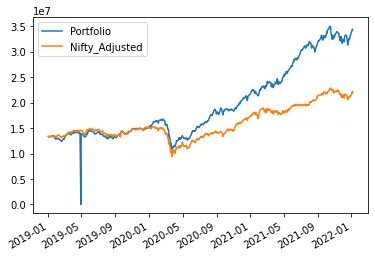

In [41]:
df_trend_compare[['Portfolio','Nifty_Adjusted']].plot()

In [42]:
df_valid_out = pd.concat([df_trend_compare[['Portfolio','Nifty_Adjusted']].iloc[1,:], df_trend_compare[['Portfolio','Nifty_Adjusted']].iloc[df_trend_compare.shape[0]-1,:]], axis=1)
df_valid_out['Profit'] = df_valid_out.iloc[:,1] - df_valid_out.iloc[:,0]
df_valid_out['Profit%'] = (df_valid_out['Profit']/df_valid_out.iloc[:,0])*100
df_valid_out

,2019-01-02 00:00:00,2022-01-06 00:00:00,Profit,Profit%
Portfolio,"13,349,505.26","34,359,935.98","21,010,430.73",157.39
Nifty_Adjusted,"13,349,505.26","21,950,335.00","8,600,829.75",64.43
